<a href="https://colab.research.google.com/github/JDM-ULL-93/Practica_2_TID/blob/master/Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de librerías

Se utilizan las librerías de numpy, matplotlib y sklearn.

* Numpy es una librería para la computación cientifica que, en este caso, usaremos para calculos de operaciones entre matrices.
* Matplotlib es una libreria para generación de graficos, útil para visualizar nuestro trabajo más adelante
* sklearn es una libreria que contiene diferentes algoritmos de aprendizaje para nuestros futuros modelos de redes neuronales




In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Carga y visualización de datos 

Cargamos nuestro datasheet a memoria.El primer datasheet es lo datos en bruto y el segundo son los mismos datos normalizado.

Nuestra base de datos se basa en las mediciones realizadas por 8 sensores sobre 8 músculos con una frecuencia de 200Hz , estas mediciones se hicieron 6 veces durante 20 segundos para cada gesto, por lo tanto:
* Tenemos un total de 64 columnas, cada una para cada sensor que mide cada musculo en cada movimiento, todas ellas de tipo float con valores dentro del rango **[-128.0,127.0]**. 
* Cada *487* filas corresponden a una de las 6 mediciones realizadas por 20 segundos para cada gesto. Este medición se hizo, de principio a fin,haciendo el mismo gesto, en una posición fija, sin transiciones de ningún tipo.
* Una última columna que representa el tipo de gesto al que se corresponde la medición:
```c#
Enum {
  Roca = 0,
  Tijeras = 1,
  Papel = 2,
  Ok = 3
}
```


En la visualización, de todos los sensores y todo lo medido, calculamos el mininimo y al maximo posible para cada tipo de gesto ('clase') y mostramos la variación entre el maximo y el minimo calculado previamente.


In [0]:
#gesturesType = {
#  'names' : ('MR1S1','MR1S2','MR1S3','MR1S4','MR1S5','MR1S6','MR1S7','MR1S8','MR2S1','MR2S2','MR2S3','MR2S4','MR2S5','MR2S6','MR2S7','MR2S8','MR3S1','MR3S2','MR3S3','MR3S4','MR3S5','MR3S6','MR3S7','MR3S8','MR4S1','MR4S2','MR4S3','MR4S4','MR4S5','MR4S6','MR4S7','MR4S8','MR5S1','MR5S2','MR5S3','MR5S4','MR5S5','MR5S6','MR5S7','MR5S8','MR6S1','MR6S2','MR6S3','MR6S4','MR6S5','MR6S6','MR6S7','MR6S8','MR7S1','MR7S2','MR7S3','MR7S4','MR7S5','MR7S6','MR7S7','MR7S8','MR8S1','MR8S2','MR8S3','MR8S4','MR8S5','MR8S6','MR8S7','MR8S8','Class') 
#  ,'formats' : (float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int)
#  }


#gestures = np.loadtxt("/content/all.csv", dtype=gesturesType, delimiter=',')
#gestures = np.loadtxt(open("/content/all.csv", "rb"), delimiter=",")
gestures = np.loadtxt("/content/all.csv", delimiter=",")
#print(gestures.shape)
#gesturesNormalized = np.loadtxt(open("/content/allNormalizedFromCommaToDots.csv", "rb"), delimiter=";")
#print(gesturesNormalized.shape)

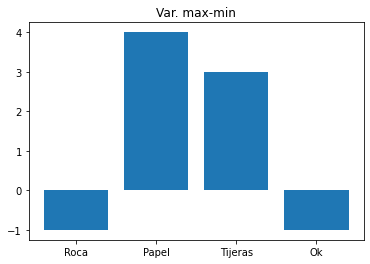

In [3]:
datos = {
  0 : {'min': +1000, 'max': -1000 },
  1 : {'min': +1000, 'max': -1000 },
  2 : {'min': +1000, 'max': -1000 },
  3 : {'min': +1000, 'max': -1000 },
}
for i in range(gestures.shape[0]):
  for j in range(64):
    index = gestures[i,64]#index = int(j/8)
    datos[index]['min'] = gestures[i,j] if gestures[i,j] < datos[index]['min'] else datos[index]['min']
    datos[index]['max'] = gestures[i,j] if gestures[i,j] > datos[index]['max'] else datos[index]['max'] 


fig = plt.figure(u'Gráfica de barras') # Figure
ax = fig.add_subplot(111) # Axes
nombres = ['Roca','Papel','Tijeras','Ok']
datosFinal = [0,0,0,0]
for i in range(4):
  datosFinal[i] = int(datos[i]['max']+datos[i]['min'])
xx = range(len(datosFinal))
ax.bar(xx, datosFinal, width=0.8, align='center')
ax.set_xticks(xx)
ax.set_xticklabels(nombres)
ax.set_title("Var. max-min")
plt.show()

# Creando conjuntos de entrenamiento, validación y test

Tras cargar y visualizar nuestros datos, procedemos a prepararlos para ser procesados posteriormente por el Perceptron Simple y Perceptron Multicapa diviendo nuestra matriz inicial contenida en 'gestures' en 3 subconjuntos, uno de entrenamiento y otro de validación que a su vez se dividirá en 2, validación de nuevo y test . ¿Por qué dividimos el conjunto de validación en 2? Porque, más adelante, en el Perceptron Multicapa, de forma indirecta, lo usamos como si fuese un conjunto de entrenamiento para optimizar los parametros de nuestro perceptron multicapa, por lo tanto, se convierten en datos viciados que ya no sirven para probar la precisión de nuestro modelo.

Conviene recalcar varias cosas:
* input_xxx : Se corresponde con el input de datos de nuestra red neuronal tipo Perceptron simple (esto es, 1 capa de entrada y otra de salida), por lo tanto, contiene toda la matrix 'gestures' pero eliminando la última columna.
* target_xxx : Basicamente es lo contrario a input, contiene solo todas las filas de la última columna y será usada siempre para validar la precisión del modelo.
* _xxx : Indica si se corresponde al subcojunto de entrenamiento(*_train*), de validación(*_valid*) o test(*_test*).

In [4]:
train_size = 0.5 #50%
test_size = 1 - train_size
#patterns_input = gesturesNormalized[:gesturesNormalized.size-1]
patterns_input = gestures[:, :-1] #Obtenemos todas las filas y columnas (excepto la última) 
patterns_target = gestures[:, -1]#gesturesNormalized[:, -1] #Obtenemos todas las filas pero solo de la ultima columna que contiene el tipo de gesto
input_train, input_valid, target_train, target_valid = train_test_split(patterns_input, patterns_target, train_size=train_size, test_size=test_size, random_state=0, shuffle=True)
print("<Conjunto_Input_Entrenamiento>.shape = ",input_train.shape)
print("<Conjunto_ValidaciónOutput_Entrenamiento>.shape = ",target_train.shape)

input_test, input_valid, target_test, target_valid = train_test_split(input_valid, target_valid, train_size=train_size,test_size=test_size, random_state=0, shuffle=True)

print("<Conjunto_Input_Validación>.shape = ",input_valid.shape)
print("<Conjunto_ValidaciónOutput_Validación>.shape = ",target_valid.shape)
print("<Conjunto_Input_Test>.shape = ",input_test.shape)
print("<Conjunto_ValidaciónOutput_Test>.shape = ",target_test.shape)

<Conjunto_Input_Entrenamiento>.shape =  (5839, 64)
<Conjunto_ValidaciónOutput_Entrenamiento>.shape =  (5839,)
<Conjunto_Input_Validación>.shape =  (2920, 64)
<Conjunto_ValidaciónOutput_Validación>.shape =  (2920,)
<Conjunto_Input_Test>.shape =  (2919, 64)
<Conjunto_ValidaciónOutput_Test>.shape =  (2919,)


# Resultados iniciales Perceptrón Simple

In [5]:
max_iter = 120
per = Perceptron(max_iter=max_iter, shuffle=False, random_state=0, verbose=True)
per.fit(input_train, target_train)
predict_train = per.predict(input_train)
predict_valid = per.predict(input_valid)
print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))

-- Epoch 1
Norm: 1228.70, NNZs: 64, Bias: -906.000000, T: 5839, Avg. loss: 4170.397328
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1213.84, NNZs: 62, Bias: -1574.000000, T: 11678, Avg. loss: 3952.304675
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1227.17, NNZs: 63, Bias: -2183.000000, T: 17517, Avg. loss: 3956.705258
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 1173.91, NNZs: 64, Bias: -2728.000000, T: 23356, Avg. loss: 3865.379688
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 1129.10, NNZs: 64, Bias: -3205.000000, T: 29195, Avg. loss: 3786.754067
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 1016.63, NNZs: 64, Bias: -3626.000000, T: 35034, Avg. loss: 3735.183593
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 884.73, NNZs: 63, Bias: -3988.000000, T: 40873, Avg. loss: 3669.783696
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 1010.13, NNZs: 64, Bias: -4310.000000, T: 46712, Avg. loss: 3625.902723
Total training time: 0.01 seconds.
-- Epoch 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


Observamos como la precisión final frente a nuestro conjunto de validación es del ~27%, es obvio que el perceptrón simple y su función lineal es totalmente incapaz de crear un modelo de red neuronal preciso,

# Resultados iniciales Perceptrón Multicapa 

El siguiente paso es probar con el Perceptrón Multicapa. Existiendo una ecuación y = f(x1,x2,...,x64), que describe como x(i) las entradas e 'y' la clase a la que se corresponde, a diferencia del perceptrón simple que solo puede intentar acotarla mediante la ecuación de una recta, el perceptrón multicapa y su adición de capas ocultas permite añadir más variables a la ecuación que acota f(x1,x2,...,x64) pudiendo acercarse más a ella, aumentando la precisión del modelo Perceptrón.  


Lo que definimos a continuación es una función que se encargará de aplicarle el algoritmo de aprendizaje encargado de ajustar pesos al perceptron multicapa que le pasamos (*mlp*) . Este algoritmo emplea el conjunto de validación como parte del entrenamiento, por lo tanto, *'vicia'* el objetivo para que estos datos fueron divididos, y por ello es que anteriormente creamos un 3º subconjunto llamado *'test'*

In [0]:
def MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, verbose):
   """
   Train and valid MLP every valid_cycles iterations
   """
   classes  = np.unique(target_train)
   loss_valid = []
   for i in range(int(max_iter/valid_cycles)):
       for j in range(valid_cycles):
           out = mlp.partial_fit(input_train, target_train, classes)
           # Calculate loss function of valid set
       last_lost_valid = log_loss(target_valid, mlp.predict_proba(input_valid))
       loss_valid.append(last_lost_valid)
       if verbose:
           print("Iteration %d, train loss = %.8f, valid loss = %.8f" %(mlp.n_iter_, mlp.loss_, last_lost_valid))
       if early_stopping and (i > 0) and (last_lost_valid > loss_valid[-2]): # Early stopping
           if verbose:
               print("Early stopping: Validation score did not improve")
           break
   if verbose: print(out)
   
   if verbose:
       # Visualizing the Cost Function Trajectory
       # (https://sdsawtelle.github.io/blog/output/week4-andrew-ng-machine-learning-with-python.html#Visualizing-the-Cost-Function-Trajectory)
       print("Visualizing the Cost Function Trajectory")
       plt.plot(range(1, len(mlp.loss_curve_)+1), mlp.loss_curve_, label='Train loss')
       plt.plot(range(valid_cycles,len(loss_valid)*valid_cycles+valid_cycles,valid_cycles), loss_valid, '-o', label='Valid loss')
       plt.xlabel('number of iterations')
       plt.ylabel('loss function')
       plt.legend(loc='upper right')
       plt.show()

Creamos nuestro MLP y se lo pasamos a la función creada anteriormente para entrenarla y mejorar su precisión

Iteration 1, loss = 9.39028203
Iteration 2, loss = 4.44213089
Iteration 3, loss = 2.72567879
Iteration 4, loss = 1.94406013
Iteration 5, loss = 1.49669749
Iteration 5, train loss = 1.49669749, valid loss = 1.73771282
Iteration 6, loss = 1.20348967
Iteration 7, loss = 0.99952973
Iteration 8, loss = 0.84916836
Iteration 9, loss = 0.73454076
Iteration 10, loss = 0.64442188
Iteration 10, train loss = 0.64442188, valid loss = 1.04893198
Iteration 11, loss = 0.57226925
Iteration 12, loss = 0.51321921
Iteration 13, loss = 0.46365460
Iteration 14, loss = 0.42091587
Iteration 15, loss = 0.38361850
Iteration 15, train loss = 0.38361850, valid loss = 0.81431302
Iteration 16, loss = 0.35124695
Iteration 17, loss = 0.32295616
Iteration 18, loss = 0.29792646
Iteration 19, loss = 0.27587965
Iteration 20, loss = 0.25639441
Iteration 20, train loss = 0.25639441, valid loss = 0.69332066
Iteration 21, loss = 0.23888045
Iteration 22, loss = 0.22313726
Iteration 23, loss = 0.20888984
Iteration 24, loss = 0

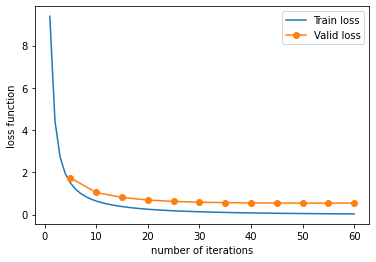

In [8]:
n_hidden = 64 #60
max_iter = 300
learning_rate_init = 0.001
valid_cycles = 5
early_stopping = True
mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=0, verbose=True)
MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, True)

In [0]:
predict_train = mlp.predict(input_train)
predict_valid = mlp.predict(input_valid)
print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))

Train accuracy: 99.777%
Valid accuracy: 86.781%
Train confusion matrix:
[[1468    0    0    0]
 [   0 1466    0    3]
 [   0    0 1429    3]
 [   0    5    2 1463]]
Valid confusion matrix:
[[679   9  29  11]
 [  1 670  21  34]
 [ 18  43 573 100]
 [ 11  54  55 612]]
Train classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1468
         1.0       1.00      1.00      1.00      1469
         2.0       1.00      1.00      1.00      1432
         3.0       1.00      1.00      1.00      1470

    accuracy                           1.00      5839
   macro avg       1.00      1.00      1.00      5839
weighted avg       1.00      1.00      1.00      5839

Valid classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       728
         1.0       0.86      0.92      0.89       726
         2.0       0.85      0.78      0.81       734
         3.0       0.81 

Observamos que, comparado al Perceptrón Simple, el Perceptrón Multicapa es mucho mas capaz de acotar esa ecuación que define la relación de los inputos con la clase (el tipo de gesto usado). Tenemos una precisión del *86.781%* para el conjunto de validación. Sin embargo, este valor todavía puede ser mejorado.

# Optimización ratio de aprendizaje
Previamente utilizamos un ratio de aprendizaje arbitario.Para acelerar la convergencia de nuestro MLP , una solución posible es buscar otro ratio de aprendizaje más óptimos.

In [0]:
tests_learning_rate_init = [0.001, 0.005, 0.01, 0.05, 0.1]
activation = 'relu'
random_state = 0
#now = datetime.now()
loss_curves =  []
for lr in tests_learning_rate_init:
   mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=lr, shuffle=False, random_state=random_state, verbose=False, activation=activation)
   MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, False)
   loss_curves.append(mlp.loss_curve_)

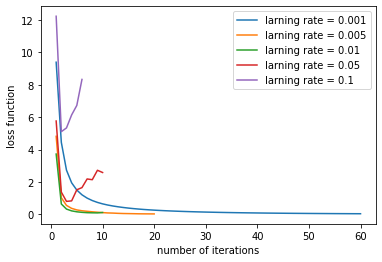

In [0]:
for (lr, loss_curve) in zip(tests_learning_rate_init, loss_curves):
   plt.plot(range(1, len(loss_curve)+1), loss_curve, label='larning rate = ' + str(lr))
plt.xlabel('number of iterations')
plt.ylabel('loss function')
plt.legend(loc='upper right')
plt.show()


Vemos que el más estable es el "learning rate" de 0.005, puesto que en solo 20 iteraciones ha reducido la variación de error al mininimo de la grafica (y por ello que 0.01 no sea mejor que 0.005, porque llega antes pero permite ajustar menos el error).

# Optimización arquitectura
Previamente tambien definimos un nuevo arbitrario de nodos ocultos igual al número de variables/inputs de nuestro modelo (64), pero no sabemos si es el adecuado. Por lo tanto, lo siguiente que realizaremos sera tratar de mejorar la precisión de nuestro MLP buscando un número de nodos ocultos más óptimos.

In [0]:
from datetime import datetime

tests_n_hidden = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]
n_reps = 10
activation = 'relu'
# activation = 'logistic'
learning_rate_init = 0.005
now = datetime.now()
best_mlp = []
best_acc = 0.0
accs_train = []
accs_valid = []
for n_hidden in tests_n_hidden:
   max_acc_train = max_acc_valid = 0.0
   for random_state in range(n_reps):
       mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=random_state, verbose=False, activation=activation)
       MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, False)
       
       acc_train = accuracy_score(target_train, mlp.predict(input_train))
       acc_valid = accuracy_score(target_valid,mlp.predict(input_valid))
       print("Seed = %d, train acc = %.8f, valid acc = %.8f, iterations = %d" % (random_state, acc_train, acc_valid, len(mlp.loss_curve_)))
       if (max_acc_valid < acc_valid):
           max_acc_valid = acc_valid
           max_acc_train = acc_train
           if (acc_valid > best_acc):
               best_acc = acc_valid
               best_mlp = mlp
   accs_train.append(max_acc_train)
   accs_valid.append(max_acc_valid)
   print("Number hidden units = %i, train acc = %.8f, max valid acc = %.8f" % (n_hidden, max_acc_train, max_acc_valid))
print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())
print("Best MLP valid accuracy: %.8f%%" % (best_acc * 100))
print("Best MLP: ", best_mlp)

Seed = 0, train acc = 0.85425587, valid acc = 0.79452055, iterations = 55
Seed = 1, train acc = 0.87840384, valid acc = 0.80650685, iterations = 60
Seed = 2, train acc = 0.86710053, valid acc = 0.79965753, iterations = 60
Seed = 3, train acc = 0.81555061, valid acc = 0.74383562, iterations = 65
Seed = 4, train acc = 0.85973626, valid acc = 0.78116438, iterations = 35
Seed = 5, train acc = 0.81041274, valid acc = 0.75171233, iterations = 40
Seed = 6, train acc = 0.86658674, valid acc = 0.79417808, iterations = 55
Seed = 7, train acc = 0.85853742, valid acc = 0.78698630, iterations = 50
Seed = 8, train acc = 0.87103956, valid acc = 0.79520548, iterations = 55
Seed = 9, train acc = 0.85237198, valid acc = 0.77534247, iterations = 75
Number hidden units = 10, train acc = 0.87840384, max valid acc = 0.80650685
Seed = 0, train acc = 0.96352115, valid acc = 0.87054795, iterations = 20
Seed = 1, train acc = 0.95889707, valid acc = 0.85753425, iterations = 20
Seed = 2, train acc = 0.97859222, v

Se observa que el mejor clasificador cuenta de 130 nodos ocultos. Observémoslo gráficamente

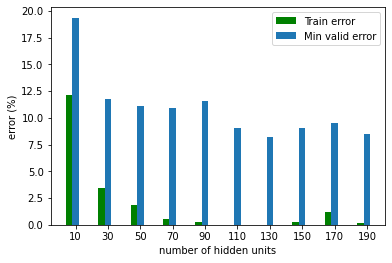

In [0]:
width = 4
plt.bar(np.array(tests_n_hidden) - width, 100 *(1- np.array(accs_train)), color='g', width=width, label='Train error')
plt.bar(np.array(tests_n_hidden), 100 *(1- np.array(accs_valid)), width=width, label='Min valid error')
plt.xlabel('number of hidden units')
plt.ylabel('error (%)')
plt.xticks(np.array(tests_n_hidden), tests_n_hidden)
plt.legend(loc='upper right')
plt.show()


# Resultados finales mejor MLP
Con el mejor MLP obtenido con los parametros optimos calculados anteriormente, se calculan la precisión y las matrices de confusión para cada subconjunto preparado (entrenamiento, validación y test).

In [0]:
predict_train = best_mlp.predict(input_train)
predict_valid = best_mlp.predict(input_valid)
predict_test = best_mlp.predict(input_test)
print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Test accuracy: %.3f%%" % (accuracy_score(target_test, predict_test) * 100))
print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Test confusion matrix:")
print(confusion_matrix(target_test, predict_test))
print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))
print("Test classification report:")
print(classification_report(target_test, predict_test))

Train accuracy: 100.000%
Valid accuracy: 91.815%
Test accuracy: 89.928%
Train confusion matrix:
[[1468    0    0    0]
 [   0 1469    0    0]
 [   0    0 1432    0]
 [   0    0    0 1470]]
Valid confusion matrix:
[[701   4  16   7]
 [  0 691  10  25]
 [ 10  34 633  57]
 [ 12  33  31 656]]
Test confusion matrix:
[[670   8  23  13]
 [  0 658  21  29]
 [ 12  34 676  55]
 [ 17  47  35 621]]
Train classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1468
         1.0       1.00      1.00      1.00      1469
         2.0       1.00      1.00      1.00      1432
         3.0       1.00      1.00      1.00      1470

    accuracy                           1.00      5839
   macro avg       1.00      1.00      1.00      5839
weighted avg       1.00      1.00      1.00      5839

Valid classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       728
        

Podemos observar como la precisión del modelo pasa de *99.78%* a *100%* de precisión para el conjunto de entrenamiento. Una variación de *+0.22%*

De *86.781%* a *91.815%* para el conjunto de validación. Una variación del *+5.034%*

Por último, de *86.781%* a *89.928%* si comparamos la precisión para el conjunto de validación de nuestro primer Perceptron MLP con la precisión para el conjunto de test para el Perceptrón MLP más óptimo . Una variación del *+3.15%*, con lo cual, podemos afirmar que nuestro modelo mejora su precisión para conjuntos de datos no viciados por el proceso de aprendizaje.

Posteriormente calculamos y visualizamos las curva ROC para el subconjunto Test:

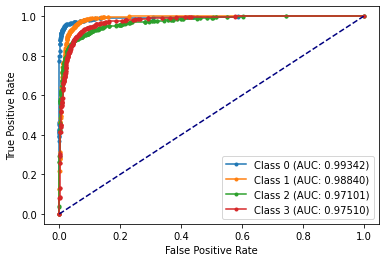

In [0]:
mlp_probs = mlp.predict_proba(input_test)
classes  = np.unique(target_train)
mlp_auc = []
mlp_fpr = []
mlp_tpr = []
for cla in classes:
  cla = int(cla)
  mlp_auc.append(roc_auc_score(target_test==cla, mlp_probs[:,cla]))
  fpr, tpr, _ = roc_curve(target_test==cla, mlp_probs[:,cla])
  mlp_fpr.append(fpr)
  mlp_tpr.append(tpr)

for cla in classes:
  cla = int(cla)
  # plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(mlp_fpr[cla], mlp_tpr[cla], marker='.', label='Class %d (AUC: %.5f)' % (cla, mlp_auc[cla]))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



Esto nos permite ver que nuestro modelo tiene un mayor indice de falsos positivos (es decir, errores) en el gesto de tipo 2, con una precisión de *97.101%*

A continuación mostramos algunas filas donde se da el falso positivo:

In [0]:
print(predict_test)
print(predict_test.shape)

gesture_test = np.column_stack( (input_test, target_test))
max_rows = 10
count = 0
for row in gesture_test:
  if max_rows == count:
    break
  if predict_test[count] != row[-1]:
    print("Fila : ", row)
    print("Se predijo : ", int(predict_test[count]), " . Era : ",int(row[-1]) )
  count = count+1


[0. 2. 1. ... 2. 2. 0.]
(2919,)
Fila :  [  9.  -1.  -4.  -7.   0. -10.   0.   2.  -8.  -1.  -1.   1.  44.  25.
  -4.  -4.   5.   3.   2.  -4. -80. -54.   7.  20. -17.   1.   1.   1.
   7.  45.   0.  -1.  -1.   0.   0.   1.   3.   1.  -2.  -4.   0.  -1.
  -1.   0.  18.  16.   5.  -4.  -2.   2.   5.   1. -12. -26.  -4.  -5.
   0.  -1.  -2.  -2.   2. -11.   0.   4.   3.]
Se predijo :  1  . Era :  3
Fila :  [  3.   2.   0.  -2. -17. -16.  -1.   3.  -7.  -3.  -1.  -2.   3.  17.
   0.   1.  16.  -2.  -2.   0.  -9.  -3.  -5.   8.  -4.   1.   3.  -1.
   3.  -2.  -9. -17.   4.  -2.  -1.   0.  25.  16.  12. -11.  -2.   4.
   2.   0. -11. -10.   3.  33. -12.  -1.  -3.   2.  -2.   5.   3.  -9.
   0.  -1.  -1.  -1.  10.   0.   3.   4.   3.]
Se predijo :  2  . Era :  3
